# Soccer Analysis
## Author: Chinanu Onyekachi

### Introduction
##### In this project, I am taking a look at statistics from soccer matches from the year 2011-2017. I will be working with two datasets (game_info.csv and match_events.csv), both of which contain information on 9074 matches across Europe's top 5 soccer leagues. With this information, I'll then try to come up with some interesting findings.

In [1]:
# Import the needed libraries
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from IPython.display import display, HTML
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split 
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest,chi2,f_classif
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

### Step A: Data Preprocessing & Cleaning

##### Read in the dataset from ginf.csv and events.csv. The dictionary.txt document explains the variables. Store the datasets in a dictionary as DataFrames. Both files have a header row containing the column names.

In [2]:
files = ["game_info.csv", "match_events.csv"]
data = {}

#Loops through each data file we downloaded.
for f in files:
    
    #Reads the file into a Pandas DataFrame and sets index columns as id_odsp
    df = pd.read_csv("football-events/{0}".format(f), header=0, index_col='id_odsp')
    
    #Puts each DataFrame into a Python dictionary.
    data[f.replace(".csv", "")] = df

#### Examine the datasets by displaying:
 
#### • the top ten records: head ()

In [3]:
#Prints the first 5 lines of each DataFrame from the data dictionary    
for key,df in data.items():
    print("\n" + key + "\n")
    display(HTML(df.head(10).to_html()))


game_info



,link_odsp,adv_stats,date,league,season,country,ht,at,fthg,ftag,odd_h,odd_d,odd_a,odd_over,odd_under,odd_bts,odd_bts_n
id_odsp,,,,,,,,,,,,,,,,,
UFot0hit/,/soccer/germany/bundesliga-2011-2012/dortmund-...,True,2011-08-05,D1,2012,germany,Borussia Dortmund,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
Aw5DflLH/,/soccer/germany/bundesliga-2011-2012/augsburg-...,True,2011-08-06,D1,2012,germany,FC Augsburg,SC Freiburg,2,2,2.36,3.60,3.40,NaN,NaN,NaN,NaN
bkjpaC6n/,/soccer/germany/bundesliga-2011-2012/werder-br...,True,2011-08-06,D1,2012,germany,Werder Bremen,Kaiserslautern,2,0,1.83,4.20,4.80,NaN,NaN,NaN,NaN
CzPV312a/,/soccer/france/ligue-1-2011-2012/paris-sg-lori...,True,2011-08-06,F1,2012,france,Paris Saint-Germain,Lorient,0,1,1.55,4.50,9.40,NaN,NaN,NaN,NaN
GUOdmtII/,/soccer/france/ligue-1-2011-2012/caen-valencie...,True,2011-08-06,F1,2012,france,Caen,Valenciennes,1,0,2.50,3.40,3.45,NaN,NaN,NaN,NaN
lOpzwMkp/,/soccer/germany/bundesliga-2011-2012/hertha-be...,True,2011-08-06,D1,2012,germany,Hertha Berlin,Nurnberg,0,1,2.06,3.75,3.95,NaN,NaN,NaN,NaN
M7PhlM2C/,/soccer/france/ligue-1-2011-2012/brest-evian-t...,True,2011-08-06,F1,2012,france,Brest,Evian Thonon Gaillard,2,2,2.29,3.25,3.85,NaN,NaN,NaN,NaN
QuWqjrYa/,/soccer/france/ligue-1-2011-2012/ac-ajaccio-to...,True,2011-08-06,F1,2012,france,AC Ajaccio,Toulouse,0,2,2.80,3.10,3.05,NaN,NaN,NaN,NaN
UBZQ4smg/,/soccer/france/ligue-1-2011-2012/nice-lyon-UBZ...,True,2011-08-06,F1,2012,france,Nice,Lyon,1,3,4.50,3.55,2.00,NaN,NaN,NaN,NaN



match_events



,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,player,player2,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break
id_odsp,,,,,,,,,,,,,,,,,,,,,
UFot0hit/,UFot0hit1,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,1,12.0,2,Hamburg SV,Borussia Dortmund,mladen petric,gokhan tore,NaN,NaN,6.0,2.0,0,9.0,2.0,1,1.0,0
UFot0hit/,UFot0hit2,2,4,"Corner, Borussia Dortmund. Conceded by Dennis...",2,NaN,1,Borussia Dortmund,Hamburg SV,dennis diekmeier,dennis diekmeier,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
UFot0hit/,UFot0hit3,3,4,"Corner, Borussia Dortmund. Conceded by Heiko ...",2,NaN,1,Borussia Dortmund,Hamburg SV,heiko westermann,heiko westermann,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
UFot0hit/,UFot0hit4,4,7,Foul by Sven Bender (Borussia Dortmund).,3,NaN,1,Borussia Dortmund,Hamburg SV,sven bender,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
UFot0hit/,UFot0hit5,5,7,Gokhan Tore (Hamburg) wins a free kick in the ...,8,NaN,2,Hamburg SV,Borussia Dortmund,gokhan tore,NaN,NaN,NaN,NaN,NaN,0,2.0,NaN,0,NaN,0
UFot0hit/,UFot0hit6,6,9,Hand ball by Jose Paolo Guerrero (Hamburg).,10,NaN,2,Hamburg SV,Borussia Dortmund,jose paolo guerrero,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
UFot0hit/,UFot0hit7,7,10,"Corner, Hamburg. Conceded by Lukasz Piszczek.",2,NaN,2,Hamburg SV,Borussia Dortmund,lukasz piszczek,lukasz piszczek,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
UFot0hit/,UFot0hit8,8,11,Chris Lowe (Borussia Dortmund) wins a free kic...,8,NaN,1,Borussia Dortmund,Hamburg SV,chris lowe,NaN,NaN,NaN,NaN,NaN,0,2.0,NaN,0,NaN,0
UFot0hit/,UFot0hit9,9,11,Foul by Gojko Kacar (Hamburg).,3,NaN,2,Hamburg SV,Borussia Dortmund,gojko kacar,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0


#### • the DataFrame column data types: dtypes

In [4]:
data['game_info'].dtypes

link_odsp     object
adv_stats       bool
date          object
league        object
season         int64
country       object
ht            object
at            object
fthg           int64
ftag           int64
odd_h        float64
odd_d        float64
odd_a        float64
odd_over     float64
odd_under    float64
odd_bts      float64
odd_bts_n    float64
dtype: object

In [5]:
data['match_events'].dtypes

id_event          object
sort_order         int64
time               int64
text              object
event_type         int64
event_type2      float64
side               int64
event_team        object
opponent          object
player            object
player2           object
player_in         object
player_out        object
shot_place       float64
shot_outcome     float64
is_goal            int64
location         float64
bodypart         float64
assist_method      int64
situation        float64
fast_break         int64
dtype: object

#####  Lookin at the data we see that  like the data for one match there are several detailed match events. Each match event is can be linked to a game by id_odps. For easier data manupilation it would be nice to have the league and season fields in the match_events table as well. We can merge those two fields to the match_events table by taking advantage of the id_odsp column.

In [6]:
# league and season column are added to match_events dataframe on the index
merged = data['match_events'].join(data['game_info'][['league', 'season']])

me_cols = (list(merged.columns.values))[:-2]
me_cols[2:4] = ['league', 'season']
merged = merged[me_cols]
data['match_events'] = merged
data['match_events'].head(10)

,id_event,sort_order,league,season,event_type,event_type2,side,event_team,opponent,player,...,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break
id_odsp,,,,,,,,,,,,,,,,,,,,,
004f4ING/,004f4ING1,1,E0,2015,8,NaN,2,Swansea,Southampton,bafetimbi gomis,...,NaN,NaN,NaN,NaN,0,1.0,NaN,0,NaN,0
004f4ING/,004f4ING2,2,E0,2015,3,NaN,1,Southampton,Swansea,maya yoshida,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
004f4ING/,004f4ING3,3,E0,2015,8,NaN,1,Southampton,Swansea,dusan tadic,...,NaN,NaN,NaN,NaN,0,5.0,NaN,0,NaN,0
004f4ING/,004f4ING4,4,E0,2015,3,NaN,2,Swansea,Southampton,neil taylor,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
004f4ING/,004f4ING5,5,E0,2015,1,12.0,1,Southampton,Swansea,james wardprowse,...,NaN,NaN,4.0,1.0,0,3.0,1.0,2,1.0,0
004f4ING/,004f4ING6,6,E0,2015,2,NaN,1,Southampton,Swansea,marvin emnes,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
004f4ING/,004f4ING7,7,E0,2015,8,NaN,1,Southampton,Swansea,ryan bertrand,...,NaN,NaN,NaN,NaN,0,4.0,NaN,0,NaN,0
004f4ING/,004f4ING8,8,E0,2015,3,NaN,2,Swansea,Southampton,jay fulton,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
004f4ING/,004f4ING9,9,E0,2015,1,12.0,2,Swansea,Southampton,bafetimbi gomis,...,NaN,NaN,12.0,2.0,0,3.0,2.0,1,1.0,0


#### • the DataFrame dimensions: shape

In [7]:
print("Game info dim: {}\nMatch events dim: {}".format(data['game_info'].shape, data['match_events'].shape))

Game info dim: (10112, 17)
Match events dim: (941009, 21)


### Step B: Clean Up Dataset
#### • Rename Leagues to proper names.

In [8]:
# displays unique league identifiers.
data['game_info']['league'].unique()

array(['D1', 'F1', 'E0', 'SP1', 'I1'], dtype=object)

In [9]:
# maps proper league names to their abbreviations.
data['game_info']['league'] = data['game_info']['league'].map({'D1':'Bundesliga','E0':'Premier League','F1':'Ligue 1','I1':'Serie A','SP1':'La Liga'})

data['match_events']['league'] = data['match_events']['league'].map({'D1':'Bundesliga','E0':'Premier League','F1':'Ligue 1','I1':'Serie A','SP1':'La Liga'})

data['game_info']['league'].unique()

array(['Bundesliga', 'Ligue 1', 'Premier League', 'La Liga', 'Serie A'], dtype=object)

#### • There is a column, adv_stats, which signifyies if there are advanced stats in the match_events table for a game. With this we can check find out how many detailed matches we have per league.

In [28]:
# creates a pivot table on on the values of adv_stats that equals to False by
# subtracting the sum of the grouped values that are True from the length
# of the grouped values. Pivot table is grouped by league then season.
adv_stats_counts = pd.pivot_table (data['game_info'], values='adv_stats',
   index=['league', 'season'], aggfunc=lambda x: [len(x), len(x)-sum(x)])

adv_stats_counts

adv_stats
league         season            
Bundesliga     2012     [306, 12]
               2013      [308, 3]
               2014     [308, 34]
               2015      [307, 0]
               2016      [308, 0]
               2017      [153, 0]
La Liga        2012     [380, 24]
               2013      [380, 0]
               2014      [380, 0]
               2015      [380, 0]
               2016      [380, 0]
               2017      [189, 0]
Ligue 1        2012     [380, 12]
               2013      [380, 7]
               2014      [379, 0]
               2015      [380, 0]
               2016      [380, 0]
               2017      [208, 0]
Premier League 2012    [380, 380]
               2013    [380, 380]
               2014     [380, 60]
               2015      [380, 0]
               2016      [380, 0]
               2017      [220, 0]
Serie A        2012     [380, 18]
               2013      [379, 0]
               2014      [380, 0]
               2015      [380, 0]
               2016      [380, 0]
               2017      [207, 0]

##### As we can see from the pivot table, there are a few inconsistencies. The Premier League has missing adv_stats for all games during the 2012 & 2013 season. There are also many games missing in some of the leagues during the 2014 season. Data from the year 2015-2017 seem to have advanced stats for all games recorded. But data from the 2017 season seems to be incomplete. Therefore we are only going to work with data from 2015-2016 to ensure consistensy in our data.

In [11]:
# copies game_info data where season is greater that 2014 into new variable.
game_info = data['game_info'][(data['game_info']['season'] > 2014)
                             & (data['game_info']['season'] < 2017)].copy()
game_info.head()

,link_odsp,adv_stats,date,league,season,country,ht,at,fthg,ftag,odd_h,odd_d,odd_a,odd_over,odd_under,odd_bts,odd_bts_n
id_odsp,,,,,,,,,,,,,,,,,
tAOylw7k/,/soccer/france/ligue-1-2014-2015/reims-paris-s...,True,2014-08-08,Ligue 1,2015,france,Stade de Reims,Paris Saint-Germain,2,2,12.00,5.40,1.44,NaN,NaN,NaN,NaN
AqTumcMe/,/soccer/france/ligue-1-2014-2015/bastia-marsei...,True,2014-08-09,Ligue 1,2015,france,Bastia,Marseille,3,3,3.95,3.44,2.22,NaN,NaN,NaN,NaN
ju6SA0E2/,/soccer/france/ligue-1-2014-2015/guingamp-st-e...,True,2014-08-09,Ligue 1,2015,france,Guingamp,St Etienne,0,2,3.25,3.15,2.67,NaN,NaN,NaN,NaN
lQOV9KT8/,/soccer/france/ligue-1-2014-2015/lille-metz-lQ...,True,2014-08-09,Ligue 1,2015,france,Lille,Metz,0,0,1.64,4.12,8.60,NaN,NaN,NaN,NaN
lzSqnHy2/,/soccer/france/ligue-1-2014-2015/evian-tg-caen...,True,2014-08-09,Ligue 1,2015,france,Evian Thonon Gaillard,Caen,0,3,2.72,3.22,3.42,NaN,NaN,NaN,NaN


In [12]:
# copies match_info data where season is greater that 2014 into new variable.
match_events = data['match_events'][(data['match_events']['season'] > 2014)
                                   & (data['match_events']['season'] < 2017)].copy()
match_events.head()

,id_event,sort_order,league,season,event_type,event_type2,side,event_team,opponent,player,...,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break
id_odsp,,,,,,,,,,,,,,,,,,,,,
004f4ING/,004f4ING1,1,Premier League,2015,8,NaN,2,Swansea,Southampton,bafetimbi gomis,...,NaN,NaN,NaN,NaN,0,1.0,NaN,0,NaN,0
004f4ING/,004f4ING2,2,Premier League,2015,3,NaN,1,Southampton,Swansea,maya yoshida,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
004f4ING/,004f4ING3,3,Premier League,2015,8,NaN,1,Southampton,Swansea,dusan tadic,...,NaN,NaN,NaN,NaN,0,5.0,NaN,0,NaN,0
004f4ING/,004f4ING4,4,Premier League,2015,3,NaN,2,Swansea,Southampton,neil taylor,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
004f4ING/,004f4ING5,5,Premier League,2015,1,12.0,1,Southampton,Swansea,james wardprowse,...,NaN,NaN,4.0,1.0,0,3.0,1.0,2,1.0,0


##### Now that our data is tidy, we can now begin analysis.

## Descriptive Statistics
### Part 1: Leagues
#### We are going to extract some descriptive statistics about the European top five leagues and how they compare to each other.

#### Goals Win You Games!
Let's see how these league fair against each other when it comes to finding the back of the net.

#### • Number of goals in each league since 2015.

In [13]:
# creates new goals column by adding scores at full time for home and away team.
game_info['goals'] = game_info['fthg'] + game_info['ftag']

# groups the game_info data by league and sums up number of goals in each league.
goals_by_league = game_info.groupby(['league'])['goals'].sum()

#### • Number of matches in each league since 2015.

In [14]:
# groups the match_events data by league and counts the number of matches 
# in each league using unique link_odsp column.
matches_by_league = game_info.groupby(['league'])['link_odsp'].count()

#### • Goals per match in each league since 2015.

In [15]:
# calculates goals per match for each league and round up to 2 decimal places.
goals_per_match = round(goals_by_league / matches_by_league, 2)

#### • Shots taken in each league since 2015.

In [16]:
# counts the number of shots taken in each league by selecting only event_types
# that are equal to 1 and grouping them by league.
shots_taken = match_events[match_events['event_type'] == 1].groupby(['league'])['event_type'].count()

#### • Goals per shot taken in each league since 2015.

In [17]:
goals_per_shot = round(goals_by_league / shots_taken, 2)

#### • Home team goals per match in each league since 2015.

In [18]:
home_goals = game_info.groupby(['league'])['fthg'].sum()
home_goals_pm = round(home_goals / matches_by_league, 2)

#### • Away team goals per match in each league since 2015.

In [19]:
away_goals = game_info.groupby(['league'])['ftag'].sum()
away_goals_pm = round(away_goals / matches_by_league, 2)

##### Next we create a new table containing our new extracted to compare the stats among the leagues.

In [20]:
goals_table  = pd.concat([matches_by_league, goals_by_league, goals_per_match, 
                          home_goals_pm, away_goals_pm, goals_per_shot], 
                         axis=1, join='inner',
                        keys=['Total Number of Matches', 
                               'Total Number of Goals',
                              'Goals per match',
                              'Home Goals per match',
                              'Away Goals per match',
                              'Goals per Shots'])

goals_table.sort_values(by=['Goals per match'], ascending=False).style\
        .bar(subset=['Total Number of Matches'], align='mid', width=95, color=['#493267'])\
        .bar(subset=['Total Number of Goals'], align='mid', width=95, color=['#666666'])\
        .bar(subset=['Goals per match'], align='mid', width=95, color=['#005b96'])\
        .bar(subset=['Home Goals per match'], align='mid', width=95, color=['#008000'])\
        .bar(subset=['Away Goals per match'], align='mid', width=95, color=['#b22222'])\
        .bar(subset=['Goals per Shots'], align='mid', width=95, color=['#daa520'])

,Total Number of Matches,Total Number of Goals,Goals per match,Home Goals per match,Away Goals per match,Goals per Shots
league,,,,,,
Bundesliga,615,1714,2.79,1.57,1.21,0.11
La Liga,760,2052,2.7,1.58,1.12,0.12
Serie A,760,2003,2.64,1.49,1.15,0.1
Premier League,760,2001,2.63,1.48,1.15,0.1
Ligue 1,760,1907,2.51,1.42,1.09,0.11


##### Across the top five leagues there are about 2-3 goals scored per match. In the Bundesliga, there are about 200 less matches played compared to the other leagues because of the fewer number of teams in the league, but that does not stop them from outdoing the others when it comes to entertaining the crowd with goals as they score the highest amount of goals per match.
##### There seems to be some kind of home advantage for teams playing in their stadium as that is reflected in the Home Goals per match column, and it seems that La Liga teams tend to benefit from that the most. Whereas, teams playing away from home in Ligue 1 have a hard time hitting the back of the net.
##### The conversion rates of the teams across the top 5 leagues are similar, but La Liga teams tip the others just a bit when it comes to finding the back of the net.

#### Rough and Tumble
The Premier League is often said to be the most physical league out of the top five European leagues. Let's see if what they say is true, we are going to look at fouls, booking and sending offs to see if the number back it up.

In [21]:
red_cards = match_events[(match_events['event_type'] == 6)].groupby(['league'])['id_event'].count()

red_cards_pm = round(red_cards / matches_by_league , 2)


In [22]:
yellow_cards = match_events[(match_events['event_type'] == 4) |
                     (match_events['event_type'] == 5)].groupby(['league'])['id_event'].count()

yellow_cards_pm = round(yellow_cards / matches_by_league , 2)


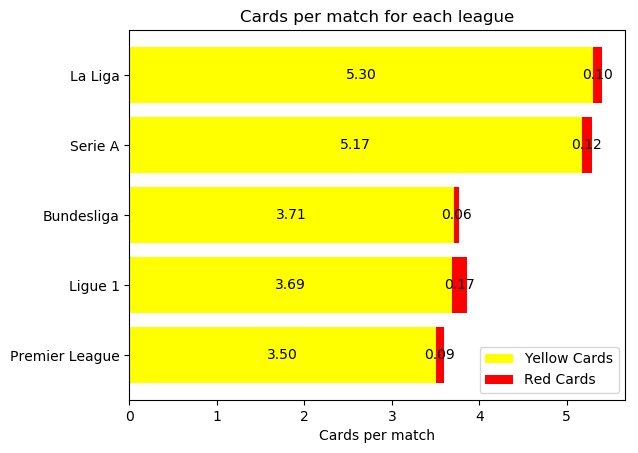

In [23]:
#resets plot to default and creates new plot
plt.rcdefaults()
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# list containing yellow & red card dataframe sorted on yellow card values
data_lst = [yellow_cards_pm[(yellow_cards_pm.sort_values()).index], 
            red_cards_pm[(yellow_cards_pm.sort_values()).index]]

# colors to be assigned to barh plot
color_lst = ["yellow", "red"]

# sets the number of tick locations to the length of the 
# indexes of our yellow card dataframe
ax.set_yticks(np.arange(len(yellow_cards_pm.index)))


# preparations for stacked horizontal bar plot

# empty list to hold plot objects
patch_handles = []

# number of unique indexes to be plotted
r = len(yellow_cards_pm.index)

# number of data points to be considered
n = 2

# number of times row will be repeated rows to be plotted, 
# here, for every unique row we have two data points, there unique rows are
# repeated twice
rows = np.array(list(np.arange(0, r)) * n)

# widths is the length of the bar, which would be the values of our 
# yellow and red card per match dataframes properly sorted.
# widths and labels have the same value, as we want to display value on bar 
# (label the bar)
widths = np.append(yellow_cards_pm[(yellow_cards_pm.sort_values()).index].values, 
                    red_cards_pm[(yellow_cards_pm.sort_values()).index].values)

labels = np.append(yellow_cards_pm[(yellow_cards_pm.sort_values()).index].values, 
                    red_cards_pm[(yellow_cards_pm.sort_values()).index].values)

# creates an array of r length to keep length of bar for each unique row
left = np.zeros(r,)

# counts number of bars in each unique row
bar_counts = np.zeros(r,)

for (r, w, l) in zip(rows, widths, labels):
    #print (r, w, l) #print to view which information will be plotted
    
    # plots bar with x coordinates of the left side of the bar starting 
    # at left[r], color is selected from list depending on the bar_count
    # then plot object is appended to patch_handles list
    patch_handles.append(ax.barh(r, w, align='center', left=left[r],
        color=color_lst[int(bar_counts[r]) % len(color_lst)]))
    
    # sets new left x coordinate as the length of bar so that 
    # new bar starts from there
    left[r] += w
    
    # keeps count of bars for coloring purposes
    bar_counts[r] += 1
    
    # gets latest bar object (last patch_handle) and selects bar
    patch = patch_handles[-1][0]
    
    # gets x and y coordinates of bar
    bl = patch.get_xy()
    
    # gets x and y coordinates of center of bar and adds label text to the center.
    x = 0.5*patch.get_width() + bl[0]
    y = 0.5*patch.get_height() + bl[1]
    ax.text(x, y, "%0.2f" % (l), ha='center',va='center')

# labels y_axis ticks with index of yellow_cards_pm            
ax.set_yticklabels((yellow_cards_pm.sort_values()).index)

# labels x axis
ax.set_xlabel('Cards per match')

#labels graph
ax.set_title('Cards per match for each league')

# adds legend to graph using matplotlib object
plt.legend((patch_handles[1], patch_handles[6]), ('Yellow Cards', 'Red Cards'))

# shows plot
plt.show()

##### Interestingly, we can see that the roughest leagues are Serie A & La Liga, both leagues get at least one more yellow card than their counterparts. Also we can see that more red cards are dished out in the French Ligue 1 compared to others.
##### Our initial belief of the Premeir League being the most physical league could be called into question here as we can see by the chart here, cards are brandished less frequently during games. Maybe the referees in these top five leagues have different standards when it comes to issuing cards to players. Let's investigate further by taking a look at the amount of fouls that occur in each game for the five leagues.

In [24]:
fouls = match_events[(match_events['event_type'] == 3)].groupby(['league'])['id_event'].count()

fouls_pm = (round(fouls / matches_by_league, 2)).sort_values()

league
Premier League    20.57
La Liga           23.40
Ligue 1           24.55
Bundesliga        26.41
Serie A           27.40
dtype: float64

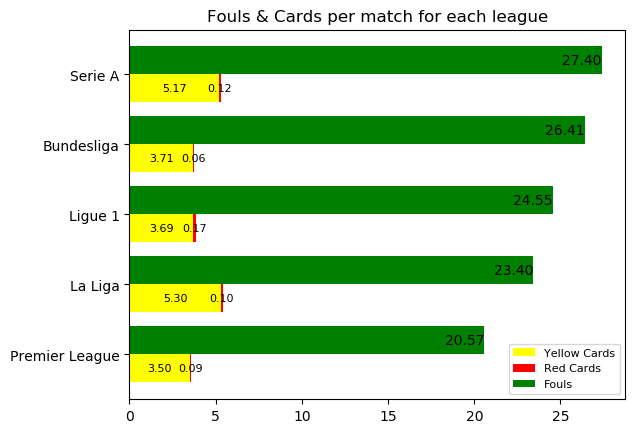

In [25]:
plt.rcdefaults()
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

data_lst = [yellow_cards_pm[fouls_pm.index], 
            red_cards_pm[fouls_pm.index]]

color_lst = ["yellow", "red"]

patch_handles = []

ax.set_yticks(np.arange(len(fouls_pm.index))+0.2)
r = len(yellow_cards_pm.index)
n = 2
rows = np.array(list(np.arange(0, r)) * n)

widths = np.append(yellow_cards_pm[fouls_pm.index].values, 
                    red_cards_pm[fouls_pm.index].values)

labels = np.append(yellow_cards_pm[fouls_pm.index].values, 
                    red_cards_pm[fouls_pm.index].values)

left = np.zeros(r,)
bar_counts = np.zeros(r,)
bar_width = 0.4

for (r, w, l) in zip(rows, widths, labels):
    patch_handles.append(ax.barh(r, w, bar_width, left=left[r],
        color=color_lst[int(bar_counts[r]) % len(color_lst)]))
    
    left[r] += w
    bar_counts[r] += 1
    patch = patch_handles[-1][0] 
    bl = patch.get_xy()
    x = 0.5*patch.get_width() + bl[0]
    y = 0.5*patch.get_height() + bl[1]
    ax.text(x, y, "%0.2f" % (l), ha='center',va='center', fontsize=8)

foul_plt = []    
for (r, i) in zip(rows, range(len(fouls_pm))):
    foul_plt.append(ax.barh(r+bar_width, (fouls_pm.values)[i], 
                            bar_width, color='green'))
    bar = foul_plt[-1][0]
    bl = bar.get_xy()
    y = 0.5*bar.get_height() + bl[1]
    x = 0.5*bar.get_width() + bl[0] + ((fouls_pm.values)[i]/2)
    ax.text(x, y, "%0.2f" % (fouls_pm.values)[i], va='center', ha='right')

    
ax.set_yticklabels(fouls_pm.index)
ax.set_title('Fouls & Cards per match for each league')
plt.legend((patch_handles[1], patch_handles[6], foul_plt[0]), 
           ('Yellow Cards', 'Red Cards', 'Fouls'), loc='lower right', fontsize=8)

plt.show()

##### As we can see, Serie A seems to be the roughest league compared to the other leagues as that is where the most fouls are committed. Suprisingly, the Bundesliga teams come really close to their Serie A counterparts when it comes to fouling, but they aren't booked as much by the referees. This could suggest that the referees in the Bundeliga are more lenient than refrees in the other leagues when it comes to giving out cards for fouls.

##### At the other end of spectrum, the referees in the Premier League don't blow their whistles for fouls so easily and when they do, they don't book the players as much as their peers do in the other leagues. I guess this is why the league is regarded as being physical, because players could possibly get away with what could possibly be considered a foul in the other leagues.

##### We can investigate this further by looking at the amount of fouls commited before referees give out cards in each league.

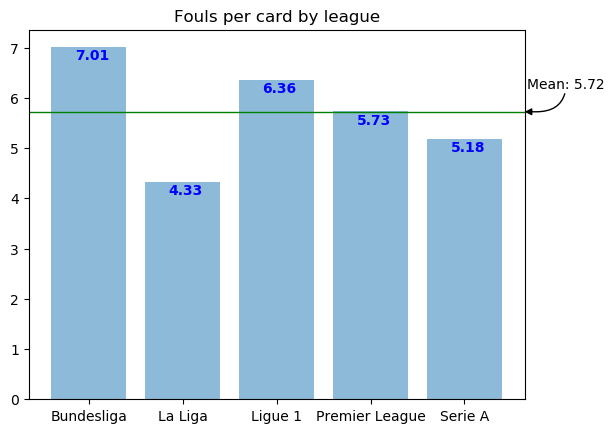

In [118]:
fouls_per_card = fouls_pm / (yellow_cards_pm + red_cards_pm)

plt.rcdefaults()
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

x_pos = np.arange(len(fouls_per_card.index))
values = fouls_per_card.values

for i, v in enumerate(values):
    ax.text(i - 0.15, v - 0.25, round(v, 2), color='blue', fontweight='bold')

ax.axhline(fouls_per_card.mean(), color='green', linewidth=1)

ax.annotate('Mean: {:0.2f}'.format(fouls_per_card.mean()), xy=(4.64, fouls_per_card.mean()), xytext=(30, 20),
            xycoords=('data'), textcoords='offset points',
            horizontalalignment='center', verticalalignment='center',
            arrowprops=dict(arrowstyle='-|>', fc='black', shrinkA=0, shrinkB=0,
                            connectionstyle='angle,angleA=90,angleB=0,rad=30'),
            )

plt.bar(x_pos, values, align='center', alpha=0.5)
plt.xticks(x_pos, fouls_per_card.index)
plt.title('Fouls per card by league')


plt.show()

##### As we can see, referees in La Liga and Serie A are more eager to dish out cards when fouls are committed, while the Bundesliga, Ligue 1 & Premeir League referees allow players to get away with fouls a lot more often.

##### We can now see why the Premier League is regared as being on of the toughest league, the referees there rarely award fouls, about 7 less than the league with the highest amount of fouls per match, as players are expected to be strong enough to ride challenges and when they do decide to book a player, the number of fouls commited would usually be higher than the average number of fouls commited before a card is given across the top five leagues.

#### Fighting against the Odds
One of the reasons soccer is the world's most popular sport is because of it's unpredictable nature which makes it so exciting to watch. An that unpredictable nature spawns some of the most memorable moments like when an underdog team pulls of a suprise win against a much stronger. Let's see how often this happens across the different leagues.

We are going to consider an upset to be where the winning team was tipped 2:1 or more to lose.

In [119]:
upsets = game_info[((game_info['fthg'] > game_info['ftag']) & (game_info['odd_h'] / game_info['odd_a'] > 2)) | 
                   ((game_info['ftag'] > game_info['fthg']) & (game_info['odd_a'] / game_info['odd_h'] > 2))]

upsets.head()

,link_odsp,adv_stats,date,league,season,country,ht,at,fthg,ftag,odd_h,odd_d,odd_a,odd_over,odd_under,odd_bts,odd_bts_n,goals
id_odsp,,,,,,,,,,,,,,,,,,
MwNw8bbL/,/soccer/france/ligue-1-2014-2015/monaco-lorien...,True,2014-08-10,Ligue 1,2015,france,AS Monaco,Lorient,1,2,1.51,4.75,11.0,NaN,NaN,NaN,NaN,3
hEmVoCdS/,/soccer/england/premier-league-2014-2015/stoke...,True,2014-08-16,Premier League,2015,england,Stoke City,Aston Villa,0,1,2.12,3.42,4.9,NaN,NaN,NaN,NaN,1
S6jJlEC9/,/soccer/england/premier-league-2014-2015/manch...,True,2014-08-16,Premier League,2015,england,Manchester Utd,Swansea,1,2,1.56,5.05,9.4,NaN,NaN,NaN,NaN,3
G0rDMcDE/,/soccer/france/ligue-1-2014-2015/marseille-mon...,True,2014-08-17,Ligue 1,2015,france,Marseille,Montpellier,0,2,1.73,3.98,6.9,NaN,NaN,NaN,NaN,2
lhLKIlCt/,/soccer/france/ligue-1-2014-2015/lyon-lens-lhL...,True,2014-08-24,Ligue 1,2015,france,Lyon,Lens,0,1,1.68,4.08,7.0,NaN,NaN,NaN,NaN,1


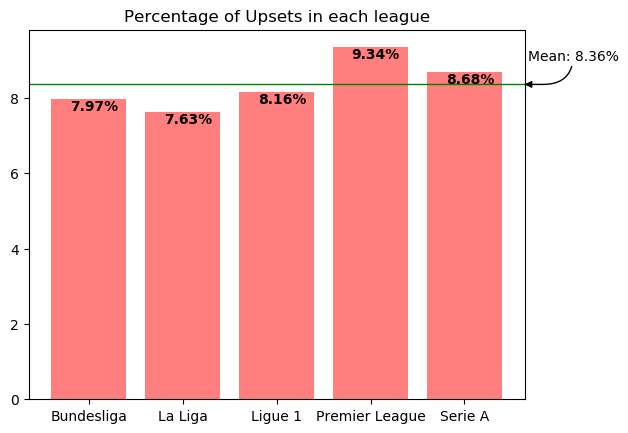

In [146]:
upsets_pl = upsets.groupby(['league'])['league'].count()

upsets_pl_pct = (upsets_pl / matches_by_league)*100


plt.rcdefaults()
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

x_pos = np.arange(len(upsets_pl_pct))
values = upsets_pl_pct.values

for i, v in enumerate(values):
    ax.text(i - 0.20, v - 0.3, str(round(v, 2)) + '%', color='black', fontweight='bold')

ax.axhline(upsets_pl_pct.mean(), color='green', linewidth=1)

ax.annotate('Mean: {:0.2f}%'.format(upsets_pl_pct.mean()), xy=(4.64, upsets_pl_pct.mean()), xytext=(35, 20),
            xycoords=('data'), textcoords='offset points',
            horizontalalignment='center', verticalalignment='center',
            arrowprops=dict(arrowstyle='-|>', fc='black', shrinkA=0, shrinkB=0,
                            connectionstyle='angle,angleA=90,angleB=0,rad=30'),
            )

plt.bar(x_pos, values, align='center', alpha=0.5, color='red')
plt.xticks(x_pos, upsets_pl_pct.index)
plt.title('Percentage of Upsets in each league')


plt.show()

##### Unsurprisingly, it is the Premier League with the highest percentage of unexpected victories, with 9.34% of the matches ending up in as an upset. That is why it is considered to be the most exciting and competitive league out of the top five leagues. 

### Part 3: Teams
#### Next, we are look at how teams in European top five leagues compare to each other.

#### Efficiency!
Let's see how well teams finish of goal scoring chances.